In [204]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [205]:
zero_noise = pd.read_csv("data/zero_noise.csv")
low_noise = pd.read_csv("data/low_noise.csv")
high_noise = pd.read_csv("data/high_noise.csv")
low_noise.drop(columns=["data_type"], inplace=True)
high_noise.drop(columns=["data_type"], inplace=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [206]:
def encode(v, class_values):
    return class_values.index(v)

def encode_target(v, class_values):
    return class_values.index(v)

class_values_zero = list(zero_noise.era.unique())
class_values_zero_target_5 = list(zero_noise.target_5_val.unique())
class_values_zero_target_10 = list(zero_noise.target_10_val.unique())
zero_noise["era_label"] = zero_noise["era"].apply(encode, args=(class_values_zero,))
zero_noise["target_5_val_label"] = zero_noise["target_5_val"].apply(encode_target, args=(class_values_zero_target_5,))
zero_noise["target_10_val_label"] = zero_noise["target_10_val"].apply(encode_target, args=(class_values_zero_target_10,))

class_values_low = list(low_noise.era.unique())
class_values_low_target_5 = list(low_noise.target_5_val.unique())
class_values_low_target_10 = list(low_noise.target_10_val.unique())
low_noise["era_label"] = low_noise["era"].apply(encode, args=(class_values_low,))
low_noise["target_5_val_label"] = low_noise["target_5_val"].apply(encode_target, args=(class_values_low_target_5,))
low_noise["target_10_val_label"] = low_noise["target_10_val"].apply(encode_target, args=(class_values_low_target_10,))

class_values_high = list(high_noise.era.unique())
class_values_high_target_5 = list(high_noise.target_5_val.unique())
class_values_high_target_10 = list(high_noise.target_10_val.unique())
high_noise["era_label"] = high_noise["era"].apply(encode, args=(class_values_high,))
high_noise["target_5_val_label"] = high_noise["target_5_val"].apply(encode_target, args=(class_values_high_target_5,))
high_noise["target_10_val_label"] = high_noise["target_10_val"].apply(encode_target, args=(class_values_high_target_10,))

dataset = high_noise
target_column = "target_5_val_label"
output_classes = 12 if target_column=="era_label" else 5

In [207]:
class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return (
            torch.tensor(self.X[index], dtype=torch.float32, device=device),
            torch.tensor(self.y[index], dtype=torch.long, device=device),
        )

In [208]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))

dataset = dataset.sample(frac=1).reset_index(drop=True)
train_dataset = dataset.iloc[:train_size]
val_dataset = dataset.iloc[train_size:train_size+val_size]
test_dataset = dataset.iloc[train_size+val_size:]

train_X = train_dataset.iloc[:, :-8].values
train_y = train_dataset.loc[:, target_column].values

val_X = val_dataset.iloc[:, :-8].values
val_y = val_dataset.loc[:, target_column].values

test_X = test_dataset.iloc[:, :-8].values
test_y = test_dataset.loc[:, target_column].values

In [209]:
train_dataset = CustomDataset(train_X, train_y)
val_dataset = CustomDataset(val_X, val_y)
test_dataset = CustomDataset(test_X, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [210]:
class MLP(nn.Module):
    def __init__(self, layers, autoencoder):
        super().__init__()
        self.layers = layers
        self.autoencoder = autoencoder
        self.linear = nn.Linear(output_classes, 1)

    def forward(self, x):
        features = x.to(device)
        subsets_list = [features[:, :16], features[:, 8:24]]
        x = self.autoencoder.aggregate(subsets_list)

        for layer in self.layers[:-1]:
            x = layer(x)

        logits = self.layers[-1](x).to(torch.float64).to(device)
        x1 = self.linear(x)
        tau = torch.sigmoid(x1).to(torch.float64).to(device)

        return logits, tau
    

class Autoencoder(nn.Module):
    def __init__(self, input_dim=24, encoding_dim=16):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 48),
            nn.ReLU(),
            nn.Linear(48, 32),
            nn.ReLU(),
            nn.Linear(32, encoding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 48),
            nn.ReLU(),
            nn.Linear(48, input_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x_recon = self.decoder(x)
        return x, x_recon

    
class NoiseAttentionLoss(nn.Module):
    def __init__(self, lambda_=1.0):
        super(NoiseAttentionLoss, self).__init__()
        self.lambda_ = lambda_

    def forward(self, logits, y, tau):
        y = F.one_hot(y, output_classes).to(torch.float64).to(device)
        perceptual = tau.squeeze(1) * (logits.t() - y.t()) + y.t()
        attention_term = torch.matmul(y, torch.log(perceptual + 1e-8))
        attention_term = attention_term.diag()
        boost_term = torch.log(tau + 1e-8) * self.lambda_

        attention_term = -torch.mean(attention_term)
        boost_term = -torch.mean(boost_term)

        return attention_term + boost_term


class SubTabLoss(nn.Module):
    def __init__(self, alpha=1, beta=1):
        super(SubTabLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, z1, z2, x_recon, x):

        recon_loss = F.mse_loss(x_recon, x)
        distance_loss = torch.mean(torch.norm(z1 - z2, dim=1))

        loss = self.alpha * recon_loss + self.beta * distance_loss
        return loss
    

class SubTab(nn.Module):
    def __init__(self, input_dim=16, encoding_dim=20, num_subsets=3):
        super(SubTab, self).__init__()
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.num_subsets = num_subsets
        self.feature_1_end = 16
        self.feature_2_end = 24
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, self.encoding_dim))
        
        self.decoder = nn.Sequential(
            nn.Linear(self.encoding_dim, 32),
            nn.ReLU(),
            nn.Linear(32, self.input_dim))
        
    def forward(self, subset):
        x = self.encoder(subset)
        x = self.decoder(x)
        return x        
    
    def aggregate(self, subsets):
        z = []
        for subset in subsets:
            z.append(self.encoder(subset).unsqueeze(0))
        z = torch.cat(z, dim=0)
        mean = torch.mean(z, dim=0)

        return mean

layers = nn.ModuleList([
        nn.Linear(20, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Linear(32, output_classes),
        nn.Softmax(dim=1),
    ])

In [211]:
autoencoder = SubTab(input_dim=16, encoding_dim=20, num_subsets=2).to(device)
model = MLP(layers, autoencoder).to(device)

learning_rate = 0.0025
learning_rate_auto = 0.001
weight_decay = 0.0001
epochs = 50
epochs_auto = 50

# criterion = nn.CrossEntropyLoss()
criterion = NoiseAttentionLoss(lambda_=50).to(device)
criterion_auto = SubTabLoss(alpha=1, beta=0)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_auto = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate_auto)

In [212]:
def train_autoencoder(model, dataloader, epochs, criterion, optimizer):
    model.train()
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0

        for features, _ in iter(dataloader):
            input = features.to(device)
            target = features.to(device)
            optimizer.zero_grad()
            outputs = model(input)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Training loss: {running_loss/len(dataloader)}")

# train_autoencoder(autoencoder, train_dataloader, epochs_auto, criterion_auto, optimizer_auto)

In [213]:
def train_subtab(model, dataloader, epochs, criterion, optimizer):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for features, _ in dataloader:
            sampled_features = []
            sampled_features.append(features[:, :16])
            sampled_features.append(features[:, 8:24])
            for subset in sampled_features:
                subset = subset.to(device)
                # print(subset.shape)
                optimizer.zero_grad()

                sub_recon = model(subset)
            
            # pos_idx = torch.randint(0, len(features), size=(len(features),))
            # z2 = model(features[pos_idx])[0]
                loss = F.mse_loss(sub_recon, subset)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Training loss: {running_loss/len(dataloader)}")

train_subtab(autoencoder, train_dataloader, 5, criterion_auto, optimizer_auto)
for parameter in autoencoder.parameters():
    parameter.requires_grad = False

Epoch 1/5 - Training loss: 0.009788712171990328
Epoch 2/5 - Training loss: 3.16264522884497e-05
Epoch 3/5 - Training loss: 2.656171187538074e-05
Epoch 4/5 - Training loss: 2.4418086545552614e-05
Epoch 5/5 - Training loss: 2.3012956699366198e-05


In [224]:
def train(model, optimizer, loss_fn, epochs, train_dataloader, val_dataloader,
          bagging_mode=False, validation_mode=True, NAL_loss=False, debug_mode=False):
    
    batch=0
    val_losses=[]
    val_accuracies=[]
    train_losses=[]
    train_accuracies=[]
    num_batches=int(len(train_dataloader)*0.9)
    for epoch in range(epochs):
        
        train_accuracy=0.0
        train_loss=0.0
        model.train()
        batch=0
        for feature ,label in iter(train_dataloader):
            optimizer.zero_grad()
            feature = feature.to(device)
            label = label.to(device)

            if NAL_loss:
                output, tau = model(feature)
                loss = loss_fn(output, label, tau)
            else:
                output, tau = model(feature)
                loss = loss_fn(output, label)

            loss.backward()
            optimizer.step()
            
            train_loss+=(loss.item())/len(label)
            train_accuracy+=torch.sum(torch.argmax(output, dim=1) == label)/len(label)

            batch+=1
            if bagging_mode:
                if batch==num_batches:
                    break
            if debug_mode:
                break
            
        train_losses.append(train_loss/len(train_dataloader))
        train_accuracies.append(train_accuracy/len(train_dataloader))

        print(f"Training loss: {train_loss}")
        print(f"Training accuracy: {train_accuracy/len(train_dataloader)}")
        print("-----------------------------------------------")
        
        if validation_mode:
            val_loss, val_acc = validation(model, val_dataloader, loss_fn)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
        batch=0

    if validation_mode:
        return train_losses, train_accuracies, val_losses, val_accuracies
    else:
        return train_losses, train_accuracies

def validation(model, val_dataloader, criterion):
    model.eval()
    val_accuracy = 0
    val_loss = 0
    with torch.no_grad():
        for feature, label in iter(val_dataloader):
            feature = feature.to(device)
            label = label.to(device)
            output = model(feature)
            val_loss += criterion(output, label).item()
            val_accuracy += torch.sum(torch.argmax(output, dim=1) == label)/len(label)
            
        print(f"Validation loss: {val_loss/len(val_dataloader)}")
        print(f"Validation accuracy: {val_accuracy/len(val_dataloader)}")

    return val_loss/len(val_dataloader), val_accuracy/len(val_dataloader)

def test(model, test_dataloader):
    model.eval()
    with torch.no_grad():
        accuracy = 0
        for feature, label in iter(test_dataloader):
            feature, label = feature.to(device), label.to(device)
            outputs, _ = model(feature)
            accuracy += torch.sum(torch.argmax(outputs, dim=1) == label)/len(label)
        print(f"Test accuracy: {accuracy/len(test_dataloader)}")

def plot(train, val, mode):
    if mode == "accuracy":
        for i in range(len(train)):
            train[i] = train[i].cpu().numpy()
    
    plt.figure(figsize=(10, 5))
    plt.plot(train, label=f"Training {mode}")
    plt.plot(val, label=f"Validation {mode}")
    plt.title(f"Training and Validation {mode} Curve")

    plt.xlabel("Epochs")
    plt.ylabel(f"{mode}")
    plt.legend()
    plt.show()

In [215]:
def bagging_train(loss_fn, epochs, train_dataloader, val_dataloader):

    models=[]
    optims=[]
    schedulers=[]
    train_losses=[]
    train_accuracies=[]
    val_losses=[]
    val_accuracies=[]
    for i in range(2):
        model = MLP(layers, autoencoder).to(device)
        models.append(model)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.003,weight_decay=0.0001)
        optims.append(optimizer)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, threshold=0.1, 
                                                               threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
        schedulers.append(scheduler)
    for epoch in tqdm(range(epochs)):
        loss=[]
        acc=[]
        for i in range (len(models)):
            model=models[i]
            optim=optims[i]
            print(f'Epoch {epoch+1}/{epochs}')
            print('***********************************************')
            print(f"Training model {i+1}")
            train_loss, train_acc=train(model,optim,loss_fn,1,train_dataloader,
                                       val_dataloader,bagging_mode=False,validation_mode=False,
                                       NAL_loss=True,debug_mode=False)
            
            loss.append(train_loss[0]); acc.append(train_acc[0])
        train_losses.append(sum(loss)/len(loss))
        train_accuracies.append(sum(acc)/len(acc))

        predictions=[]
        labels=[]
        losses = []
        for model in models:
            model.eval()
            accuracy = 0
            running_loss = 0
            model_predictions=[]
            model_labels=[]
            with torch.no_grad():
                for feature, label in iter(val_dataloader):
                    feature = feature.to(device)
                    label = label.to(device)
                    output, tau = model(feature)
                    prediction = torch.argmax(output, dim=1)
                    model_predictions.extend(prediction.item() for prediction in prediction)
                    model_labels.extend(label.item() for label in label)
                    loss = loss_fn(output, label, tau)
                    running_loss += loss.item()/len(label)
            losses.append(running_loss)
            predictions.append(model_predictions)
            labels.append(model_labels)

        val_loss = sum(losses)/len(losses)
        final_labels=labels[0]
        final_predictions=[]
        for i in range(len(predictions[0])):
            current_predictions=[prediction[i] for prediction in predictions]
            final_predictions.append(max(set(current_predictions), key=current_predictions.count))
        accuracy = sum(1 for x,y in zip(final_predictions, final_labels) if x==y)/len(final_predictions)
        val_losses.append(val_loss)
        val_accuracies.append(accuracy)

        print(f"Validation loss: {val_loss}")
        print(f"Validation accuracy: {accuracy}")
        print("===============================================")
    return models, train_losses, train_accuracies, val_losses, val_accuracies

In [216]:
criterion = NoiseAttentionLoss(lambda_=50).to(device)
bagging_models, train_losses, train_accuracies, val_losses, val_accuracies = bagging_train(criterion, 20, train_dataloader, val_dataloader)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
***********************************************
Training model 1
Training loss: 65.2960711070525
Training accuracy: 0.4622395932674408
-----------------------------------------------
Epoch 1/20
***********************************************
Training model 2
Training loss: 53.11660031459486
Training accuracy: 0.5339643359184265
-----------------------------------------------
Validation loss: 6.503026098438811
Validation accuracy: 0.5418669871794872
Epoch 2/20
***********************************************
Training model 1
Training loss: 50.46502471949159
Training accuracy: 0.5569511651992798
-----------------------------------------------
Epoch 2/20
***********************************************
Training model 2
Training loss: 49.14805521717754
Training accuracy: 0.5677534341812134
-----------------------------------------------
Validation loss: 6.035951569229428
Validation accuracy: 0.5778846153846153
Epoch 3/20
***********************************************
Training mod

## High Noise Target-10

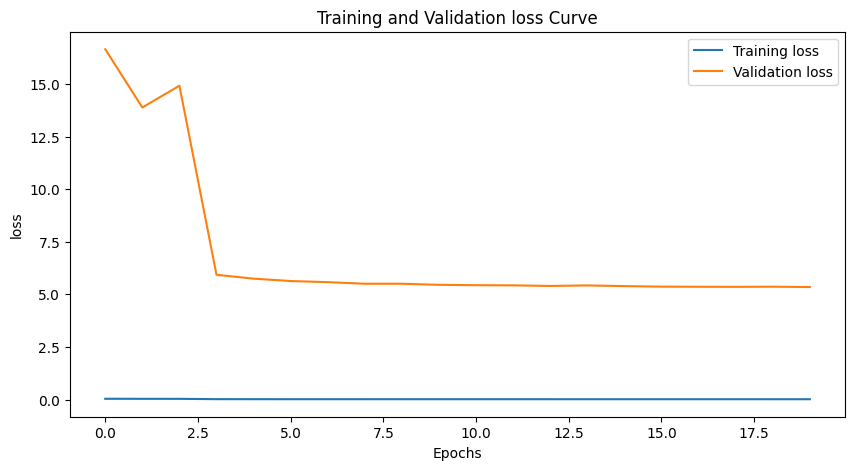

In [190]:
plot(train_losses, val_losses,"loss")

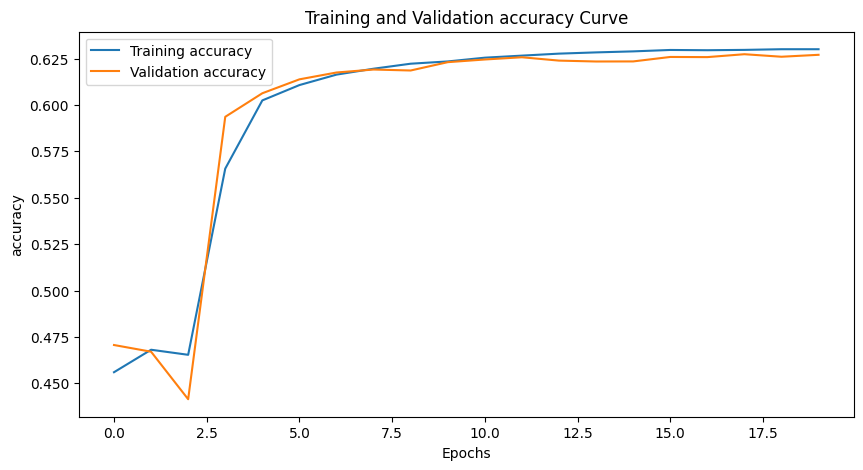

In [191]:
plot(train_accuracies, val_accuracies,"accuracy")

## High Noise Target-5

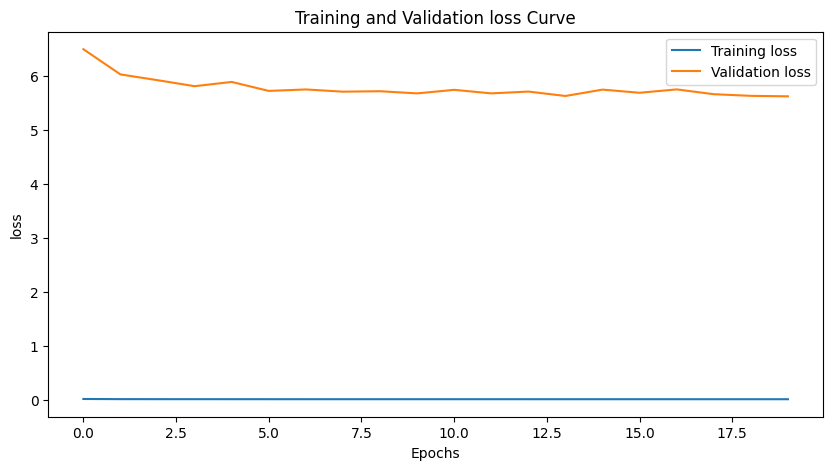

In [217]:
plot(train_losses, val_losses,"loss")

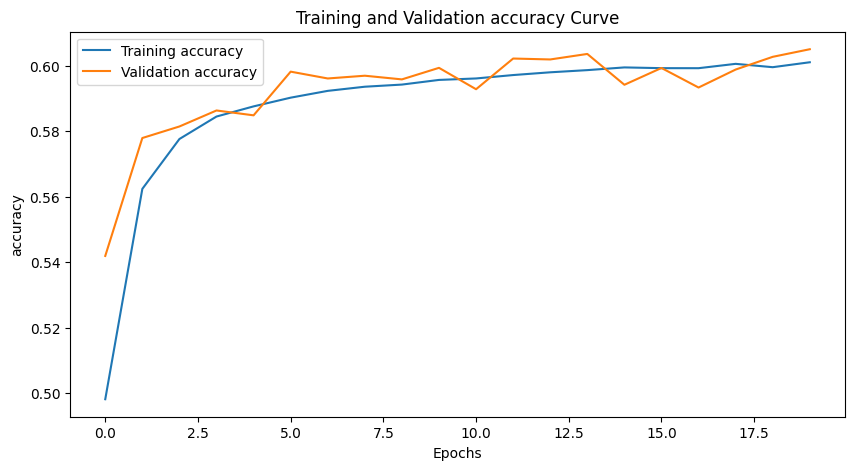

In [225]:
plot(train_accuracies, val_accuracies,"accuracy")